# Enhancing Information Retrieval from SwissRe Reports with ColPali: A Contextual and Vision-Augmented RAG Approach

Retrieving information from PDFs is challenging due to the variety of components they contain, such as text, images, tables, headings, captions, and complex layouts.

Conventional RAG models rely on a series of intricate steps for parsing PDFs:
1. OCR (Optical Character Recognition) to extract text from scanned documents.
2. Layout recognition to understand the structure of pages.
3. Figure captioning to associate images with their corresponding text.
4. Chunking to break down long documents into manageable pieces.
5. Embedding to convert these chunks into vectors for efficient retrieval.

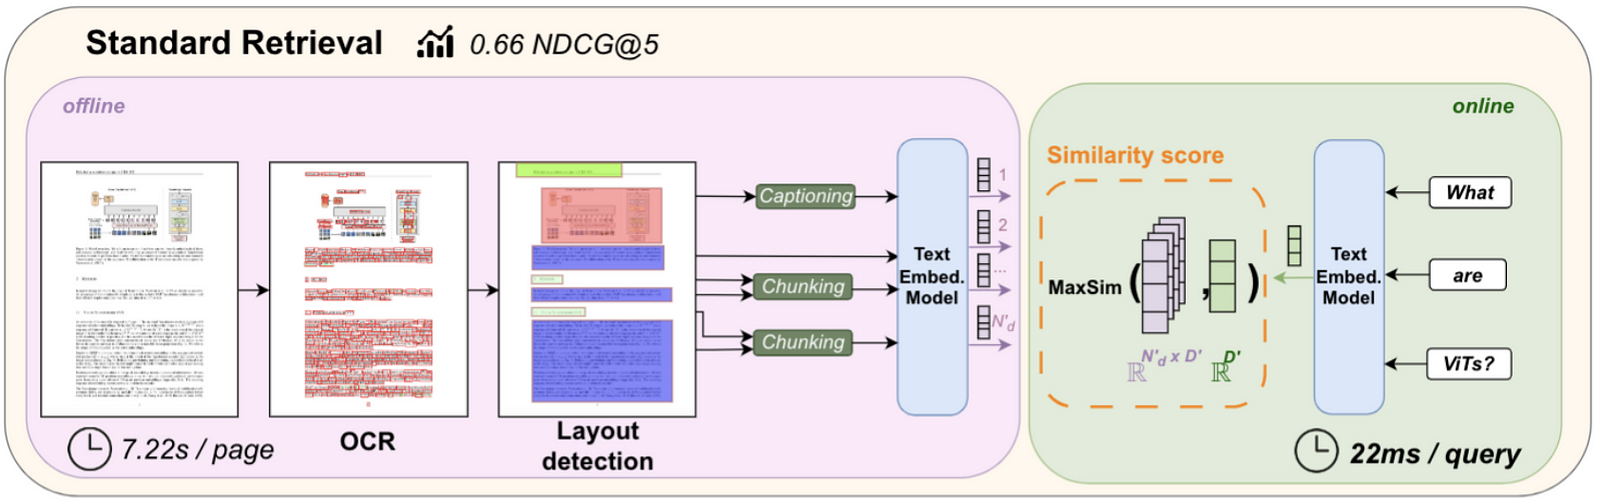

ColPali indexes documents efficiently by focusing solely on their visual features, using page screenshots to simplify the process and reduce complexity

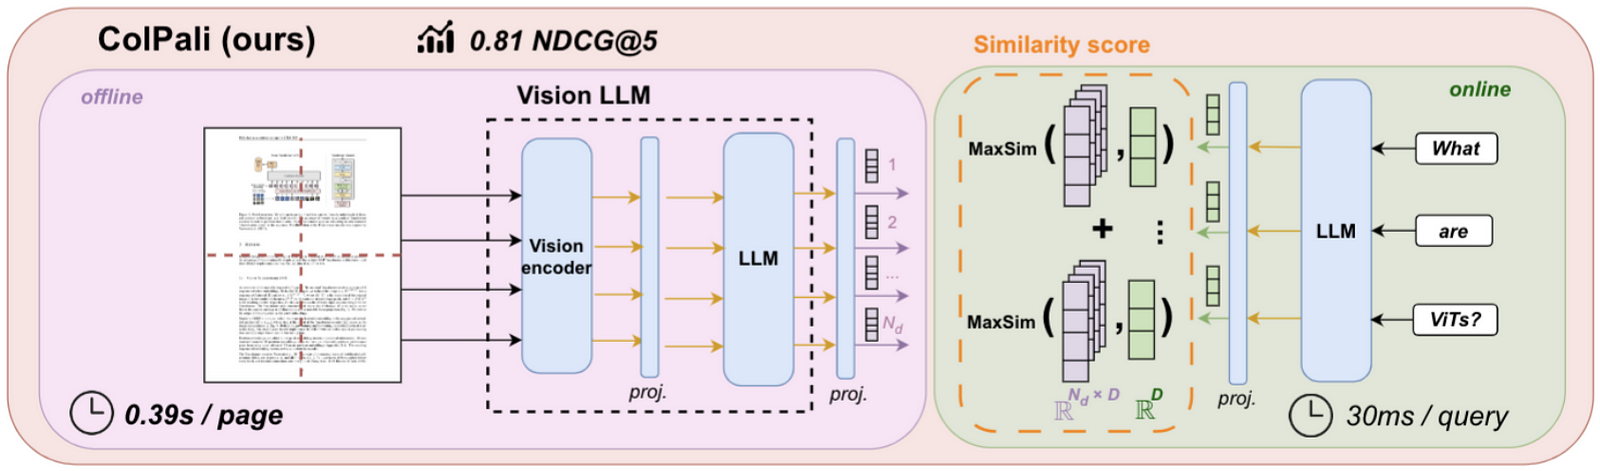

## Libraries Used

1. **accelerate**: Efficiently handles multi-GPU and distributed training for deep learning models.
2. **flash_attn**: Optimized attention implementation to speed up transformer-based models.
3. **qwen_vl_utils**: Utility functions for working with Qwen Vision-Language models.
4. **pdf2image**: Simple conversion of PDF documents to image formats for easier processing.
5. **groq**: Enables accelerated inference on Groq hardware for performance improvements.
6. **torch**: PyTorch, a flexible and widely-used deep learning library for building and training models.
7. **transformers**: Hugging Face library providing access to state-of-the-art transformer models for NLP and beyond.


In [ ]:
#!pip install -qU byaldi
!pip install -qU accelerate flash_attn qwen_vl_utils pdf2image groq torch transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
import requests, base64, os, time
from groq import Groq
from PIL import Image


## Download data and mount google drive, api keys

In [ ]:
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

HUGGINGFACE_API_KEY = userdata.get('HuggingFace_read')
GROQ_API_KEY = userdata.get("GROQ_API_KEY")

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo'

if not os.path.exists(folder_path):
    !git clone https://github.com/AnswerDotAI/byaldi.git {folder_path}
else:
    print(f"The folder '{folder_path}' already exists. Skipping download.")

The folder '/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo' already exists. Skipping download.


In [ ]:
# Hugging Face Inference API endpoint
API_URL = "https://api-inference.huggingface.co/models/meta-llama/Llama-3.2-11B-Vision-Instruct"

# Your Hugging Face API key
headers = {"Authorization": f"Bearer {HUGGINGFACE_API_KEY}"}

# Input message
data = {
    "inputs": "What are different categories of Property & Casualty risks coveredby Swiss Re?",
}

# Sending request to the API
response = requests.post(API_URL, headers=headers, json=data)

# Output response
print(response.json())


[{'generated_text': '  \nSwiss Re is a global provider of reinsurance and insurance solutions. Here are some different categories of Property & Casualty (P&C) risks that Swiss Re covers:\n\n**1. Fire and Allied Perils:**\n   - Fire: covering damage to property due to fire\n   - Lightning: covers damage caused by lightning strikes\n   - Wind: provides coverage for damage caused by windstorms\n   - Flood: insures against loss or damage caused by water inundation\n   - Nuclear'}]


In [ ]:
folder_path = '/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo_new'

if not os.path.exists(folder_path):
    !git clone https://github.com/AnswerDotAI/byaldi.git {folder_path}
else:
    print(f"The folder '{folder_path}' already exists. Skipping download.")

The folder '/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo_new' already exists. Skipping download.


## Load the ColPali with RAGMultiModal from byaldi

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo_new

/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo_new


**poppler-utils**: A set of command-line tools for working with PDF files, including conversion and extraction utilities.

In [ ]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (157 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123621 

In [ ]:
!pip install -e "." -q # Installs the current package in editable mode, allowing live code changes without reinstalling.

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Building editable for Byaldi (pyproject.toml) ... done


In [ ]:
from byaldi import RAGMultiModalModel  # Imports RAG-based multi-modal model for information retrieval
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor  # Imports vision-language model, tokenizer, and processor from Hugging Face
from qwen_vl_utils import process_vision_info  # Utility function to handle visual data processing for Qwen VL model
from pdf2image import convert_from_path  # Converts PDF pages to image format for further processing
import groq  # Imports for acceleration on Groq hardware
import torch

In [ ]:
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2", verbose=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

## Indexing PDF Files with byaldi

We initialize a pretrained `RAGMultiModalModel` with the ColPali model from Hugging Face. The model is loaded on the CPU to avoid conflicts with the Qwen2-VL model on the GPU. If the index doesn't exist, it is created by processing documents, extracting embeddings, and storing them in systems like ChromaDB or Weaviate for efficient retrieval.


In [ ]:
# First-time creation of the index from the input PDF
# RAG.index(
#     input_path="/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/reports/swissre_insurance/sigma-4-2023-en.pdf",
#     index_name="/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/Index/swissre_index",
#     store_collection_with_index=False, overwrite=True
# )

# Loading the previously saved index for retrieval
RAG = RAGMultiModalModel.from_index("/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/swissre_index")


Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/byaldi_repo_new/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch

## Query text

In [ ]:
text_query = "What is life real premium growth in Europe compared to China?"
results = RAG.search(text_query, k=3)
results

[{'doc_id': 0, 'page_num': 26, 'score': 16.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 5, 'score': 16.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 33, 'score': 15.9375, 'metadata': {}, 'base64': None}]

In [ ]:
text_query2 ="What is total share of commercial and personal lines in non-life premiums market in 2022, by line of business? Explain the reasoning and give back corresponding image or text from the reference"
results2 = RAG.search(text_query2, k=3)
results2

[{'doc_id': 0, 'page_num': 19, 'score': 29.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 44, 'score': 27.5, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 16, 'score': 27.0, 'metadata': {}, 'base64': None}]

## Convert to actual Image Data

In [ ]:
images = convert_from_path("/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/reports/swissre_insurance/sigma-4-2023-en.pdf")
image_index = results[0]["page_num"] -1
image_index2 = results2[0]["page_num"] -1


In [ ]:
image_index, image_index2

(25, 18)

## Display the Chosen Document Image

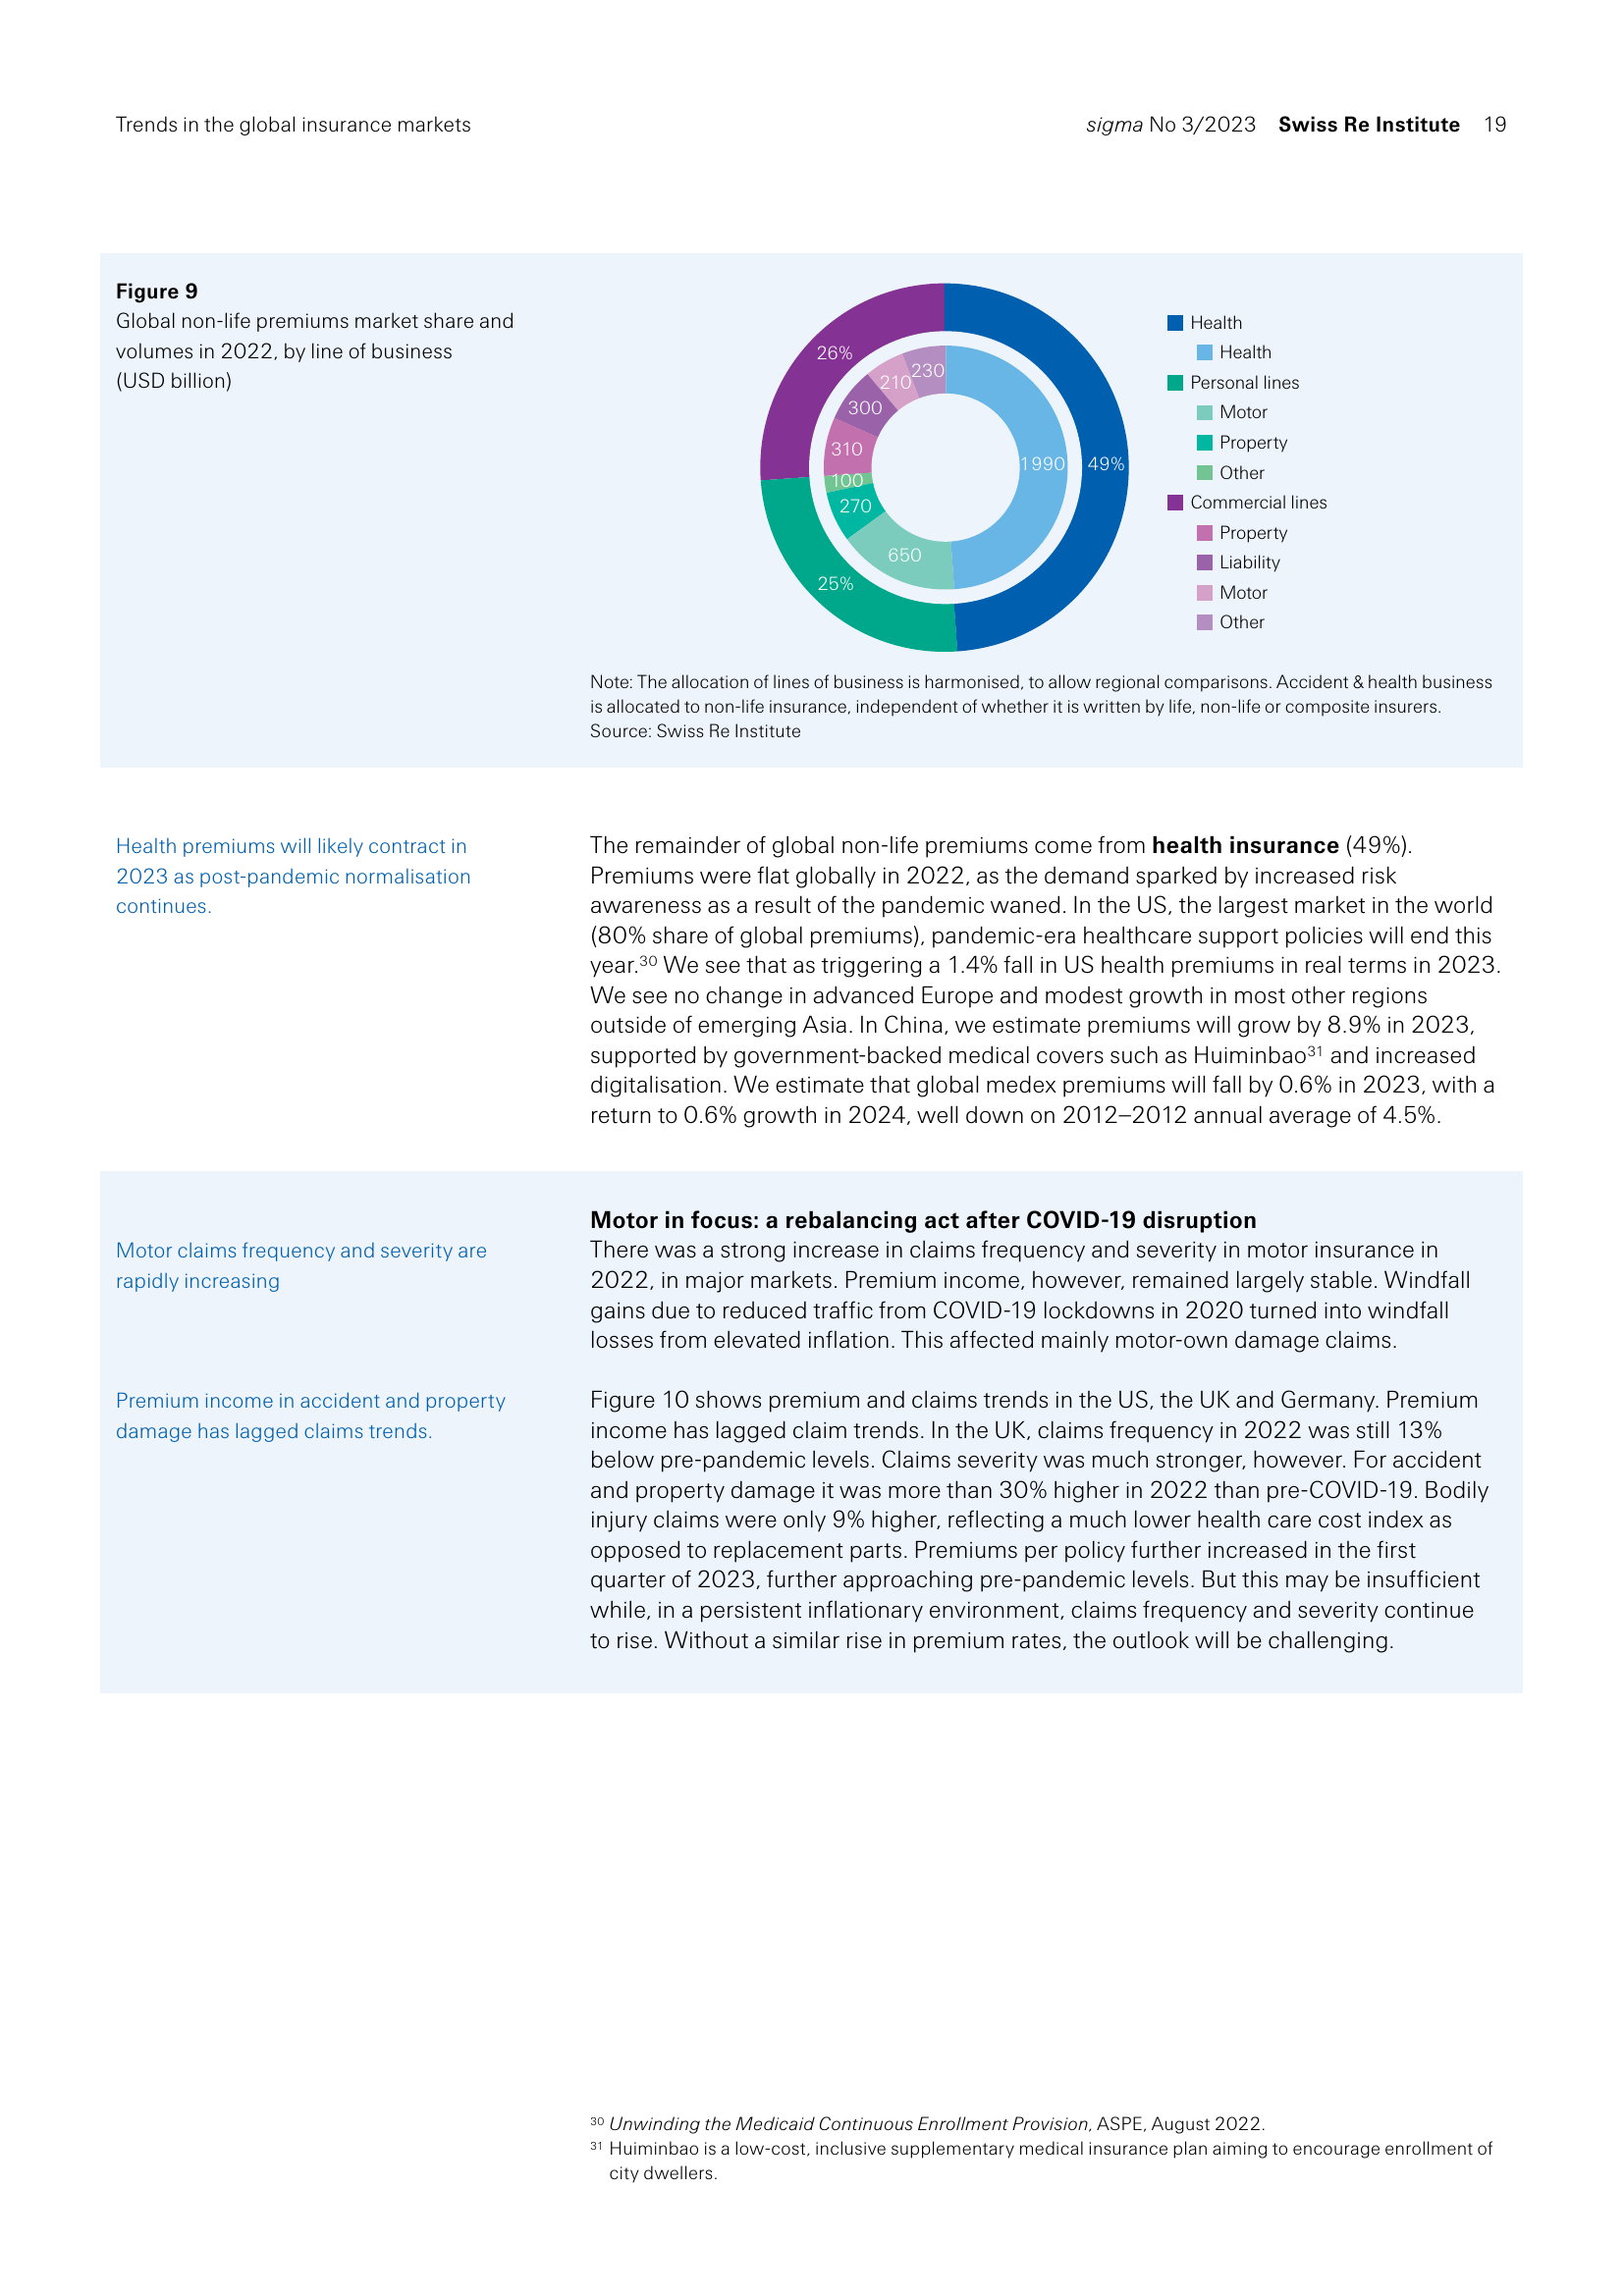

In [ ]:
from IPython.display import Image,display
display(images[image_index2])

## Save the extracted images from swiss re reports

In [ ]:
images[image_index].save('/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/byaldi_extracted_images/image.jpg')
images[image_index2].save('/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/byaldi_extracted_images/image2.jpg')

## Synthesize response using GROQ - llava-v1.5-7b-4096-preview model

## LLaVA V1.5 7B (Preview)

* Model ID: llava-v1.5-7b-4096-preview
* Description: LLaVA (Large Language-and-Vision Assistant) is an open-source, fine-tuned multimodal model that can generate text descriptions of images, achieving impressive performance on multimodal instruction-following tasks and outperforming GPT-4 on certain benchmarks.
* Context Window: 4,096 tokens

## Limitations
* Preview Model: Llava V1.5 7B is currently in preview and should be used for experimentation.
* Image Size Limit: The maximum allowed size for a request containing an image URL as input is 20MB.
* Requests larger than this limit will return a 400 error.
* Request Size Limit (Base64 Enconded Images): The maximum allowed size for a request containing a base64 encoded image is 4MB. Requests larger than this limit will return a 413 error.
* Single Image per Request: Only one image can be processed per request. Requests with multiple images will return a 400 error.
* Single User Message per Request: Multi-turn conversations are not currently supported and only one user message is allowed per request. Requests with multiple user messages will return a 400 error.
* No System Prompt or Assistant Message: System messages and assistant messages are currently not supported. Requests including system or assistant messages will return a 400 error.
* No Tool Use: Tool Use is not currently supported. Requests with tool use or function calling will return a 400 error.
* No JSON Mode: JSON Mode is not currently supported. Requests with JSON Mode enabled will return a 400 error.

In [ ]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/byaldi_extracted_images/image2.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq()

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text_query2},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llava-v1.5-7b-4096-preview",
)

print(chat_completion.choices[0].message.content)

According to the reference text, the share of premiums in the non-life insurance market continued to shift towards more commercial business in 2022. In life and non-life insurance, the combined share of premiums has been rising while in property and casualty classes, the trend has been different due to a significant rally in the casualty rate in 2022. The trend data presented is from 2008 to the present. In recent years, there has shown an expanding spread between the casualty and property products.


This trend is most likely impacted by the companies' strategy and the evolution in client needs and preferences. The changes over certain years indicate how the market is adapting to these altering insurance demand patterns.


The image featured in the reference shows a pie-shaped data visualization that represents a combination of non-life insurance and property and casualty classes, showing their growing relative shares in insurance premiums.


In [ ]:
text_query

'What is life real premium growth in Europe compared to China?'

In [ ]:
# Path to your image
image_path = "/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/byaldi_extracted_images/image2.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq()

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text_query2},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llava-v1.5-7b-4096-preview",
)

print(chat_completion.choices[0].message.content)

According to the reference, the total share of commercial and personal lines in non-life premiums market in 2022, by line of business, is as follows:


* Commercial lines: 80%
* Personal lines: 20%


Looking at the fact that commercial line products are provided to businesses, such as corporations, these products make up 80% of the non-life premiums in the market. Conversely, personal line products, like auto and home insurance, constitute the remaining 20%.


The reasoning for this dominance comes from the fact the commercial lines face economic value in the market, and their insurance premiums reflect the cost of reinsurance and the reinsurance buys in several lines. Personal lines are usually written at loss ratio in adoption factor by line of commodity mix which is why personal lines and treatments more expensive than commercial. Therefore, these businesses pay better taxes and maintain more investments.


In [ ]:
# Path to your image
image_path = "/content/drive/MyDrive/ColabNotebooks/LangChain-RAG/data/byaldi_extracted_images/image.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq()

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": text_query},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llava-v1.5-7b-4096-preview",
)

print(chat_completion.choices[0].message.content)


Life Real Premium Growth in Europe compared to china varies significantly. In 2013, the real premium growth rate in Europe was a higher figure compared to that of last year. This may indicate an increase in wealth inequality, increasing demand for life insurance in Europe. An increase in Chinese life insurance premium growth is expected, with a promising future for Asian markets, as the population strengthens support, and the middle-class grows in size. This growing population may also lead to increased demand for life insurance in the future. Experts suggest that companies with exposure to these markets should consider the future potential and develop suitable strategies.
